In [1]:
import os
import sys

sys.path.insert(0, os.path.abspath("..")) 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from models import Haldane
from pythtb import *
from wanpy import *

In [3]:
# tight-binding parameters
delta = 1
t = 1
t2 = -0.3

n_super_cell = 2
model = Haldane(delta, t, t2).make_supercell([[n_super_cell, 0], [0, n_super_cell]])

#############

n_orb = model.get_num_orbitals()
lat_vecs = model.get_lat()
orb_vecs = model.get_orb()
low_E_sites = np.arange(0, n_orb, 2)
high_E_sites = np.arange(1, n_orb, 2)
n_occ = int(n_orb/2)

bloch_eigstates = Bloch(model, 20, 20)
bloch_eigstates.solve_model()
chern = bloch_eigstates.chern_num().real

model_str = f'C={chern:.1f}_Delta={delta}_t={t}_t2={t2}'

print(f"Low energy sites: {low_E_sites}")
print(f"High energy sites: {high_E_sites}")
print(f"Chern # occupied: {chern: .1f}")

Computing flux in plane: mu=0, nu=1
Low energy sites: [0 2 4 6]
High energy sites: [1 3 5 7]
Chern # occupied:  1.0


In [4]:
### Trial wavefunctions

# only one should be true
low_E = False

omit_sites = 6
tf_sites = list(np.setdiff1d(low_E_sites, [omit_sites])) # delta on lower energy sites omitting the last site
tf_list = [ [(orb, 1)] for orb in tf_sites]
n_tfs = len(tf_list)
Wan_frac = n_tfs/n_occ

save_sfx = model_str + f'_tfx={np.array(tf_sites, dtype=int)}'

print(f"Trial wavefunctions: {tf_list}")
print(f"# of Wannier functions: {n_tfs}")
print(f"# of occupied bands: {n_occ}")
print(f"Wannier fraction: {Wan_frac}")
print(save_sfx)

Trial wavefunctions: [[(np.int64(0), 1)], [(np.int64(2), 1)], [(np.int64(4), 1)]]
# of Wannier functions: 3
# of occupied bands: 4
Wannier fraction: 0.75
C=1.0_Delta=1_t=1_t2=-0.3_tfx=[0 2 4]


In [5]:
sv_dir = 'data'
if not os.path.exists(sv_dir):
    os.makedirs(sv_dir)
    
sv_prefix = 'WF_max_loc'
file_name = f"{sv_dir}/{sv_prefix}_{save_sfx}"

WF = np.load(f"{file_name}.npy", allow_pickle=True).item()

sv_prefix = 'WF_loc_steps'
file_name = f"{sv_dir}/{sv_prefix}_{save_sfx}"

loc_steps = np.load(f"{file_name}.npy", allow_pickle=True).item()

In [6]:
for key, val in loc_steps.items():
    print(f"{key}: Omega = {sum(val['Omega'])/3: .4f}")

P: Omega =  0.2646
P+ML: Omega =  0.2638
P+SS+P: Omega =  0.2022
P+SS+P+ML: Omega =  0.2018


In [7]:
for key, val in loc_steps.items():
    print(key, val)

P {'Omega': array([0.26456629, 0.26456629, 0.26456629]), 'Omega_i': np.float64(0.6868298950186045), 'Omega_til': np.float64(0.10686896932807521), 'centers': array([[0.16759885, 0.16759885],
       [0.16759885, 0.6648023 ],
       [0.6648023 , 0.16759885]])}
P+ML {'Omega': array([0.26375204, 0.26375204, 0.26375204]), 'Omega_i': np.float64(0.686829895019855), 'Omega_til': np.float64(0.10442623276342951), 'centers': array([[0.16761256, 0.16761256],
       [0.16761256, 0.66477489],
       [0.66477489, 0.16761256]]), 'iter_num': 100000}
P+SS+P {'Omega': array([0.20215881, 0.20215881, 0.20215881]), 'Omega_i': np.float64(0.5706005404455823), 'Omega_til': np.float64(0.03587588762123564), 'centers': array([[0.16122706, 0.16122706],
       [0.16122706, 0.67754588],
       [0.67754588, 0.16122706]]), 'iter_num': 100000}
P+SS+P+ML {'Omega': array([0.20183802, 0.20183802, 0.20183802]), 'Omega_i': np.float64(0.5706005404466907), 'Omega_til': np.float64(0.034913530260350815), 'centers': array([[0.161

# Plotting

(<Figure size 640x480 with 1 Axes>, <Axes: >)

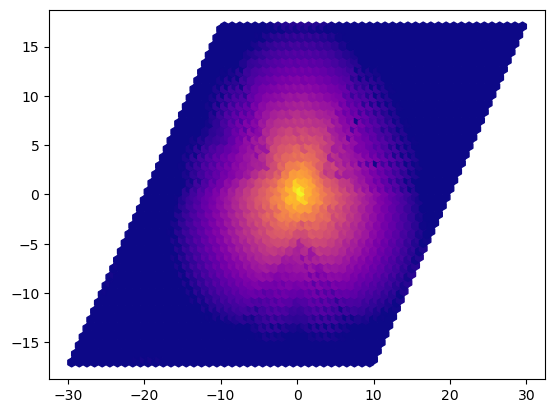

In [8]:
plot_density(WF, 0, show_lattice=False, lat_size=2, cbar=False, return_fig=True, interpolate=False)

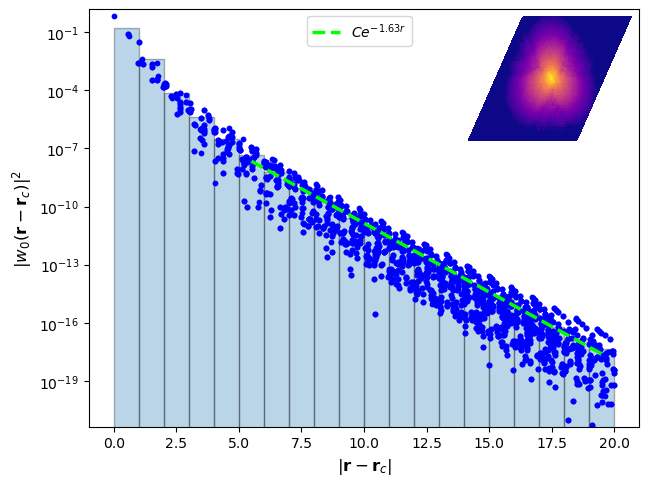

In [9]:
idx = 0
fig, ax = plot_decay(WF, idx, fit_rng=[5, 20], return_fig=True)
ax.legend(bbox_to_anchor=(0.6, 1.0))
inset_ax = inset_axes(ax, width="30%", height="30%", loc='upper right')  # You can adjust size and location
fig, inset_ax = plot_density(
    WF, idx, show_lattice=False, lat_size=2, cbar=False, interpolate=True, fig=fig, ax=inset_ax, return_fig=True)
inset_ax.set_xticks([])
inset_ax.set_yticks([])
inset_ax.axis('off')
plt.subplots_adjust(top=0.98, left=0.12, bottom=0.11, right=0.98)
plt.savefig(f'figures/fig3_decay_and_dens_{save_sfx}.png', dpi=700)

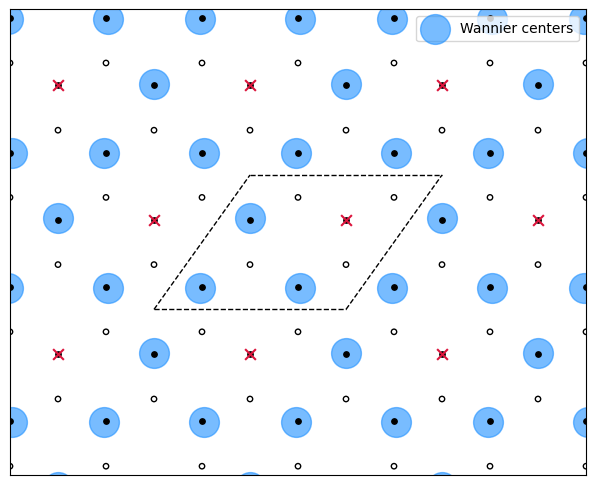

In [10]:
title = (
  "Haldane model \n"
  fr"$C = {chern: .1f}$, $\Delta = {delta}$, $t= {t: .2f}, t_2 = {t2: .2f}$"
  )

# kwargs_centers = {'marker': '*', 'c': 'dodgerblue', 'alpha': 0.6} 
kwargs_centers = {'marker': 'o', 'c': 'dodgerblue', 'alpha': 0.6} 
# kwargs_omit = {'s': 70, 'marker': 'x', 'c': 'k', 'zorder': 3} 
kwargs_omit = {'s': 60, 'marker': 'x', 'c': 'crimson', 'zorder': 3} 
kwargs_lat_ev = {'s': 15, 'marker': 'o', 'c': 'k'} 
kwargs_lat_odd = {'s': 15, 'marker': 'o', 'facecolors':'none', 'edgecolors':'k'} 

fig, ax = plot_centers(
    WF, title=title, center_scale=50, omit_sites=[omit_sites], section_home_cell=True, 
    color_home_cell=False, translate_centers=True, kwargs_centers=kwargs_centers, 
    kwargs_lat_ev=kwargs_lat_ev, kwargs_lat_odd=kwargs_lat_odd, kwargs_omit=kwargs_omit, 
    pmx=3, pmy=3, legend=True)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title('')

sv_dir = 'figures'
sv_prefix = 'fig4_Wan_centers'
file_name = f"{sv_dir}/{sv_prefix}_{save_sfx}.png"

# plt.subplots_adjust(top=1, left=0, bottom=0, right=1)
plt.subplots_adjust(top=0.98, left=0.05, bottom=0.01, right=.95)

plt.savefig(file_name, dpi=700)

In [11]:
u_energy = WF.energy_eigstates.get_states()["Cell periodic"]  # energy eigenstates
P, Q = WF.energy_eigstates.get_projector(return_Q=True)  # full band projector

u_occ = u_energy[..., :n_occ, :]  # occupied energy eigenstates
P_occ = np.einsum("...ni, ...nj -> ...ij", u_occ, u_occ.conj())  # occupied band projector
Q_occ = np.eye(P_occ.shape[-1]) - P_occ[..., :, :]  # occ complement

u_tilde = WF.tilde_states.get_states()["Cell periodic"]  # reduced tilde states
P_triv, Q_triv = WF.tilde_states.get_projector(return_Q=True)  # tilde space projectors

## Projectors on full mesh
P_top = P_occ - P_triv  # complementary subspace
Q_top =  np.eye(P_top.shape[-1]) - P_top[..., :, :] 

eigvals, eigvecs = np.linalg.eigh(P_top)  # states spanning complement
u_top = eigvecs[..., :, -1]  # take state with non-zero eigval
u_top = u_top[..., np.newaxis, :]  # single state

In [12]:
k_path = [[0, 0], [2/3, 1/3], [.5, .5], [1/3, 2/3], [0, 0], [.5, .5]]
k_label = (r'$\Gamma $',r'$K$', r'$M$', r'$K^\prime$', r'$\Gamma $', r'$M$')
(k_vec, k_dist, k_node) = model.k_path(k_path, 501, report=False)

# Actual eigenstates and eigenenergies
evals, evecs = model.solve_ham(k_vec, return_eigvecs=True)
n_eigs = evecs.shape[-2]

# Reduced Wannier interpolated energies and states
interp_energies_triv, interp_unk_triv = WF.interp_energies(k_vec, ret_eigvecs=True)

# Complementary subspace interpolated energies and states
interp_energies_top, interp_unk_top = WF.interp_energies(k_vec, u_tilde=u_top, ret_eigvecs=True) 

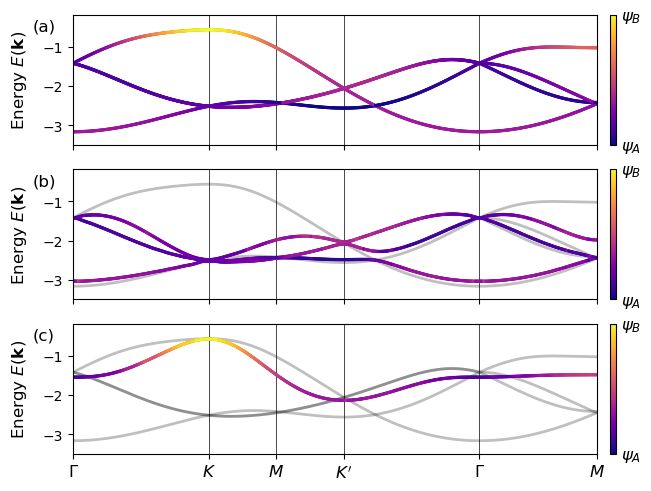

In [13]:
fig, axs = plt.subplots(3, 1, sharex=True, constrained_layout=True)

############# subplot a ####################

# Actual bands
wt = abs(evecs)**2
col = np.sum([ wt[..., i] for i in high_E_sites], axis=0)
for n in range(evals.shape[-1]):
    axs[0].plot(k_dist, evals[:, n], c='k', lw=2, zorder=0)

    scat = axs[0].scatter(
        k_dist, evals[:, n], c=col[:, n], 
        cmap='plasma', marker='o', s=2, vmin=0, vmax=1, zorder=2)
    
cbar = fig.colorbar(scat, ticks=[1,0], pad=0.01)
cbar.ax.set_yticklabels([r'$\psi_B$', r'$\psi_A$'], size=12)
# cbar.ax.set_yticklabels([])
cbar.ax.tick_params(size=0) 

axs[0].set_xlim(0, k_node[-1])
axs[0].set_xticks([ ])
for n in range(len(k_node)):
    axs[0].axvline(x=k_node[n], linewidth=0.5, color='k', zorder=1)

axs[0].set_ylabel(r"Energy $E(\mathbf{{k}})$", size=12)
axs[0].yaxis.labelpad = 10
axs[0].set_ylim(-3.5, -0.18)

axs[0].text(-.1, -0.6, '(a)', size=12)

############# subplot b ####################

# Actual bands
for n in range(evals.shape[-1]):
    axs[1].plot(k_dist, evals[:, n], c='k', lw=2, zorder=0, alpha=0.25)

# Reduced bands
wt = abs(interp_unk_triv)**2
col = np.sum([ wt[..., i] for i in high_E_sites], axis=0)
for n in range(interp_energies_triv.shape[-1]):
    axs[1].plot(k_dist, interp_energies_triv[:, n], c='k', lw=2, zorder=0)

    scat = axs[1].scatter(
            k_dist, interp_energies_triv[:, n], c=col[:, n], 
            cmap='plasma', marker='o', s=2, vmin=0, vmax=1, zorder=2
            )

cbar = fig.colorbar(scat, ticks=[1,0], pad=0.01)
cbar.ax.set_yticklabels([r'$\psi_B$', r'$\psi_A$'], size=12)
cbar.ax.tick_params(size=0) 

axs[1].set_xlim(0, k_node[-1])
axs[1].set_xticks([ ])
for n in range(len(k_node)):
    axs[1].axvline(x=k_node[n], linewidth=0.5, color='k', zorder=1)

axs[1].set_ylabel(r"Energy $E(\mathbf{{k}})$", size=12)
axs[1].yaxis.labelpad = 10
axs[1].set_ylim(-3.5, -0.18)

axs[1].text(-.1, -0.6, '(b)', size=12)

############# subplot c ####################

# Actual bands
for n in range(evals.shape[-1]):
    axs[2].plot(k_dist, evals[:, n], c='k', lw=2, zorder=0, alpha=0.25)

# topological bands
wt = abs(interp_unk_top)**2
col = np.sum([ wt[..., i] for i in high_E_sites], axis=0)
for n in range(interp_energies_top.shape[-1]):
    axs[2].plot(k_dist, interp_energies_top[:, n], c='k', lw=2, zorder=0)

    scat = axs[2].scatter(
            k_dist, interp_energies_top[:, n], c=col[:, n], 
            cmap='plasma', marker='o', s=2, vmin=0, vmax=1, zorder=2)

cbar = fig.colorbar(scat, ticks=[1,0], pad=0.01)
cbar.ax.set_yticklabels([r'$\psi_B$', r'$\psi_A$'], size=12)
cbar.ax.tick_params(size=0) 

axs[2].set_xlim(0, k_node[-1])
axs[2].set_xticks(k_node)
for n in range(len(k_node)):
    axs[2].axvline(x=k_node[n], linewidth=0.5, color='k', zorder=1)
if k_label is not None:
    axs[2].set_xticklabels(k_label, size=12)

axs[2].set_ylabel(r"Energy $E(\mathbf{{k}})$", size=12)
axs[2].yaxis.labelpad = 10
axs[2].set_ylim(-3.5, -0.18)
axs[2].text(-.1, -0.6, '(c)', size=12)

#######################

plt.savefig(f"figures/fig5_interp_all_bands_{save_sfx}.png", dpi=700)

In [15]:
prod = np.einsum("...ij, ...jk -> ...ik", P_triv, P_top)

prod[0,0].round(3)

array([[ 0.+0.j, -0.+0.j,  0.+0.j, -0.-0.j, -0.-0.j, -0.+0.j,  0.-0.j,
         0.+0.j],
       [-0.-0.j,  0.+0.j, -0.-0.j,  0.+0.j, -0.+0.j,  0.-0.j, -0.+0.j,
         0.-0.j],
       [ 0.-0.j, -0.+0.j,  0.+0.j, -0.+0.j,  0.+0.j,  0.+0.j,  0.-0.j,
        -0.-0.j],
       [-0.+0.j,  0.-0.j, -0.-0.j,  0.-0.j,  0.+0.j,  0.-0.j, -0.+0.j,
         0.+0.j],
       [-0.+0.j,  0.-0.j,  0.-0.j,  0.-0.j,  0.-0.j,  0.-0.j,  0.+0.j,
        -0.+0.j],
       [-0.-0.j,  0.+0.j, -0.-0.j,  0.+0.j,  0.+0.j,  0.-0.j, -0.-0.j,
        -0.-0.j],
       [ 0.+0.j, -0.-0.j,  0.+0.j, -0.-0.j,  0.-0.j, -0.+0.j,  0.-0.j,
        -0.+0.j],
       [ 0.-0.j,  0.+0.j, -0.+0.j,  0.-0.j, -0.-0.j, -0.+0.j, -0.-0.j,
         0.-0.j]])